In [1]:
import sys
sys.path.append('/Users/reuben204/Reuben/Biomarker Finding/libexpr/algorithms')
import importlib

In [2]:
import pandas as pd
import numpy as np
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from scipy.ndimage import gaussian_filter1d
from itertools import product
from tqdm import tqdm

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.feature_selection import RFE
from sklearn.model_selection import LeaveOneOut, StratifiedKFold, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, StratifiedShuffleSplit, ParameterGrid
from sklearn.utils import resample
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, \
    precision_recall_curve, auc, average_precision_score
from sklearn.inspection import permutation_importance

In [4]:
import rutils as rt

In [5]:
importlib.reload(rt);

# Data Loading

In [6]:
edata_df = pd.read_csv('../mutual-data/merged_edata.tsv', sep='\t', index_col=0)
mdata_df = pd.read_csv('../mutual-data/merged_mdata.tsv', sep='\t', index_col=0)
print( np.all(edata_df.columns == mdata_df.index) )

with open('../wgcna/common_genes.txt') as f:
	filter_genes = f.readlines()

gene_names = np.array([l for line in filter_genes if (l:=line.strip()) != ''])
print(f'{gene_names.size=}')

edata_df = edata_df.loc[gene_names,]
X = edata_df.T.to_numpy()
y = np.int_(mdata_df.condition == 'SC')

True
gene_names.size=101


In [7]:
np.logspace(-3, 3, 10)

array([1.00000000e-03, 4.64158883e-03, 2.15443469e-02, 1.00000000e-01,
       4.64158883e-01, 2.15443469e+00, 1.00000000e+01, 4.64158883e+01,
       2.15443469e+02, 1.00000000e+03])

# LR

In [8]:
param_dict = {
    'C': [0.01, 0.1, 1, 10],
    'l1_ratio': [0.25, 0.4, 0.5, 0.6, 0.75]
}
len(ParameterGrid(param_dict))

20

In [9]:
# lr = LogisticRegression(
#     penalty='elasticnet', solver='saga',
#     class_weight='balanced',
#     max_iter=10_000, random_state=123
# )

In [54]:
score_arr_param = []
param_bucket = []
for i, param in enumerate(ParameterGrid(param_dict)):
    lr = LogisticRegression(
        penalty='elasticnet', solver='saga',
        class_weight='balanced',
        max_iter=10000, random_state=674414,
        **param
    )
    boot, oob = rt.evaluateBootstrap(X, y, lr, n_boot=400, metric=rt.pr_auc, use_proba=True, seed=379858+i)
    score_arr_param.append(oob)
    param_bucket.append(param.copy())
    rt.iterLog(i)

score_arr_param = np.array(score_arr_param)

Iteration - 19

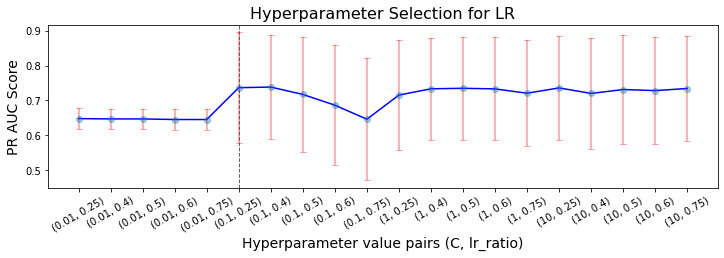

In [79]:
plt.figure(figsize=(12, 3))
plt.axvline(5, alpha=0.6, ls='--', c='black', lw=1)
rt.errorPlot(score_arr_param, axis=1)
plt.xticks(range(20), [(p['C'], p['l1_ratio']) for p in param_bucket], rotation=30, fontsize=10)
plt.title('Hyperparameter Selection for LR', fontsize=16)
plt.xlabel('Hyperparameter value pairs (C, lr_ratio)', fontsize=14)
plt.ylabel('PR AUC Score', fontsize=14)
plt.show()

In [ ]:
# print(np.where(score_arr.mean(1)>score_arr.mean(1).max()))
print(np.argsort(score_arr_param.mean(1))[::-1])
print(score_arr_param.mean(1)[np.argsort(score_arr_param.mean(1))[::-1]])
np.where(score_arr_param.mean(1) > score_arr_param.mean(1).max() - score_arr_param.var(1, ddof=1))

[ 6  5 15 12 19 11 13 17 18 14 16  7 10  8  0  2  1  9  3  4]
[0.73833808 0.73654295 0.73583713 0.73482316 0.73418542 0.7333139
 0.73306374 0.73124848 0.7282001  0.72067872 0.72005864 0.71726492
 0.71533881 0.68644118 0.64794319 0.64700461 0.64699661 0.64616167
 0.64532533 0.6452925 ]


(array([ 5,  6,  7, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]),)

In [23]:
print(param_bucket[5])
best_param = param_bucket[13]

{'C': 0.1, 'l1_ratio': 0.25}


In [24]:
lr_model = LogisticRegression(
    penalty='elasticnet', solver='saga',
    class_weight='balanced',
    max_iter=10000, random_state=58,
    **best_param
    # C=0.1, l1_ratio=0.25
)

In [25]:
n_boot = 1000
rnd = np.random.default_rng(37335)
coef_arr = []
score_arr = []
for i in range(n_boot):
    X_boot, X_oob, y_boot, y_oob = rt.bootstrap_resample(X, y, rnd_engine=rnd)
    scaler = StandardScaler()
    X_boot_scaled = scaler.fit_transform(X_boot)
    X_oob_scaled = scaler.transform(X_oob)

    lr_model.fit(X_boot_scaled, y_boot)
    coef_arr.append(lr_model.coef_[0])
    rt.iterLog(i)

    # y_oob_pred_proba = model.predict_proba(X_oob_std)[:, 1]
    score_arr.append(
        rt.pr_auc(y_oob, lr_model.predict_proba(X_oob_scaled)[:, 1])
    )

coef_arr = np.array(coef_arr)
score_arr = np.array(score_arr)
print()
print(score_arr.mean(), score_arr.var(ddof=1))
# score_arr

Iteration - 999
0.7376279149676793 0.02312322844609073


In [26]:
median_coef = np.median(np.abs(coef_arr), axis=0)
gene_names[median_coef!=0]

array(['ALDH3A1', 'PIR', 'MICALL1', 'GPAA1', 'RFXANK', 'ZNF444', 'CLTB',
       'TXNRD1', 'NUMA1', 'HYOU1', 'RNF40', 'ETFB', 'NCOR2', 'HRAS',
       'HMG20B', 'FGFR3', 'NDUFV1'], dtype='<U10')

In [102]:
boot, oob = rt.evaluateBootstrap(X, y, lr_model, median_coef!=0, n_boot=1000, use_proba=False, metric=f1_score, seed=37335)
oob.mean(), oob.var(ddof=1)

(0.7441680115635998, 0.015768911235349205)

In [105]:
rt.evaluateLOO(X, y, median_coef!=0, lr_model, use_proba=True, metric=rt.pr_auc)

0.8103641380141052

In [28]:
np.median(coef_arr, axis=0)[median_coef!=0]

array([-0.7761949 , -0.28346705,  0.07549627,  0.12546989,  0.02772657,
        0.05958871,  0.69665834, -0.08197036,  0.24597086,  0.04389465,
       -0.08310332,  0.1570904 ,  0.19781888,  0.40043555,  0.29862895,
        0.19046383, -0.15130951])

In [29]:
coef_arr.mean(0)[median_coef!=0]

array([-0.76584549, -0.32552916,  0.17437886,  0.24275547,  0.15664913,
        0.23383767,  0.68034498, -0.17875169,  0.29822202,  0.17610169,
       -0.21185225,  0.20450733,  0.27114101,  0.45323711,  0.3923285 ,
        0.24496578, -0.28774184])

In [30]:
import seaborn as sns

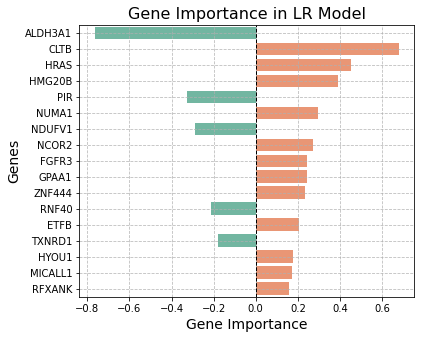

In [ ]:
gene_importance = pd.Series(
    coef_arr.mean(0)[median_coef!=0],
    index=gene_names[median_coef!=0]
)
gene_importance_sorted = gene_importance.reindex(gene_importance.abs().sort_values(ascending=False).index)
colors = ['Protective' if val < 0 else 'Risk' for val in gene_importance_sorted]


plt.figure(figsize=(6, 5))
sns.barplot(x=gene_importance_sorted.values, y=gene_importance_sorted.index, hue=colors, palette='Set2', legend=False)
plt.grid(axis="y", linestyle="--", alpha=0.85)


plt.xlabel("Gene Importance", fontsize=14)
plt.ylabel("Genes", fontsize=14)
plt.title("Gene Importance in LR Model", fontsize=16)
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
plt.grid(axis='x', linestyle='--', alpha=0.85)


plt.show()


In [80]:
# rt.writeln(gene_importance.index)

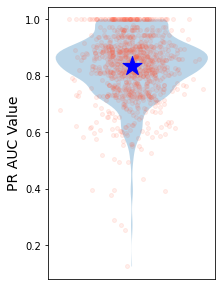

In [99]:
plt.figure(figsize=(3, 5))
vp = plt.violinplot(oob, widths=0.5, showmeans=False)
for violin in vp['bodies']:
    # violin.set_facecolor('tomato')  # Set fill color
    # violin.set_edgecolor('black')   # Set border color
    violin.set_alpha(0.3)  
# vp['cbars'].set_visible(False) 
for part in ['cbars', 'cmins', 'cmaxes']:
    vp[part].set_visible(False)

plt.scatter(np.random.normal(1, 0.07, 1000), oob, s=16, alpha=0.10, c='tomato')
plt.scatter([1], [oob.mean()], marker='*', s=400, label="Mean", c='blue')
plt.xticks([])
plt.ylabel('PR AUC Value', fontsize=14)
plt.show()

In [ ]:
## MEAN RANK

In [415]:
max_rank = np.argsort(np.mean(np.abs(coef_arr), axis=0))[::-1]
gene_names[max_rank][:30]

array(['ALDH3A1', 'CLTB', 'HRAS', 'HMG20B', 'PIR', 'NUMA1', 'NDUFV1',
       'NCOR2', 'FGFR3', 'GPAA1', 'ZNF444', 'RNF40', 'MICALL1', 'ETFB',
       'TXNRD1', 'ECH1', 'SYBU', 'HYOU1', 'RFXANK', 'SMPD1', 'POLR2E',
       'ASF1A', 'TAX1BP3', 'RB1CC1', 'CHPF2', 'ACTN4', 'SLC25A11',
       'PRMT1', 'PRKCSH', 'RBM10'], dtype='<U10')

In [386]:
score_arr = []
for i in range(1, 30):
    fidx = max_rank[:i]
    boot, oob = rt.evaluateBootstrap(X, y, lr_model, fidx, n_boot=100, use_proba=True, metric=rt.pr_auc, seed=i)
    score_arr.append(oob)
    rt.iterLog(i)
score_arr = np.array(score_arr)

Iteration - 29

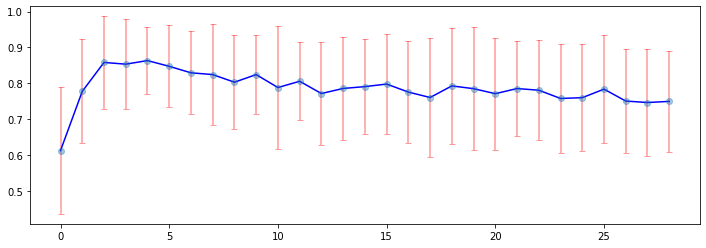

In [387]:
plt.figure(figsize=(12, 4))
rt.errorPlot(score_arr, axis=1)

In [393]:
print(score_arr.mean(1)[2:10])
score_arr.mean(1) > score_arr.mean(1).max() - score_arr.var(ddof=1)

[0.85828893 0.8534739  0.86345915 0.84743835 0.82934754 0.82445158
 0.80310139 0.82443242]


array([False, False,  True,  True,  True,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False])

In [330]:
# X_subset = StandardScaler().fit_transform(X[:, median_coef!=0])
# lr_model.fit(X_subset, y)
# lr_model.coef_[0]

array([-0.87861848, -0.26615908,  0.42869162,  0.36610975,  0.38080299,
        0.23260585,  1.01554638,  0.        ,  0.53083123,  0.26877739,
       -0.465509  ,  0.38592822,  0.47406964,  0.35484865,  0.57867919,
        0.52856765, -1.11886872])